In [1]:
# Library
library(dplyr)
library(tidyverse)
library(sf)
library(sparr)
library(spatstat)


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.5.0
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

필요한 패키지를 로딩중입니다: spatstat

필요한 패키지를 로딩중입니다: spatstat.data

필요한 패키지를 로딩중입니다: spatstat.geom

spatstat.geom 3.0-6

필요한 패키지를 로딩중입니다: spatstat.random

spatstat.random 3.1-3

필요한 패키지를 로딩중입니다: spatstat.explore

필요한 패키지를 로딩중입니다: nlme


다음의 패키지를 부착합니다: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


spatstat.explore 3.0-6

필요한 패키지를 로딩중입니다: sp

In [2]:
# load area(Daejeon grid)
DJ_area = read_sf('data/CENSUS/grid_DJ_100M.gpkg')
head(DJ_area)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



GRID_100M_,geom
<chr>,<POLYGON [m]>
다바848000,POLYGON ((229763.4 299957.5...
다바849000,"POLYGON ((229863.5 299958, ..."
다바850000,POLYGON ((229963.5 299958.5...
다바851000,"POLYGON ((230063.5 299959, ..."
다바852000,POLYGON ((230163.6 299959.5...
다바853000,POLYGON ((230263.6 299960.1...


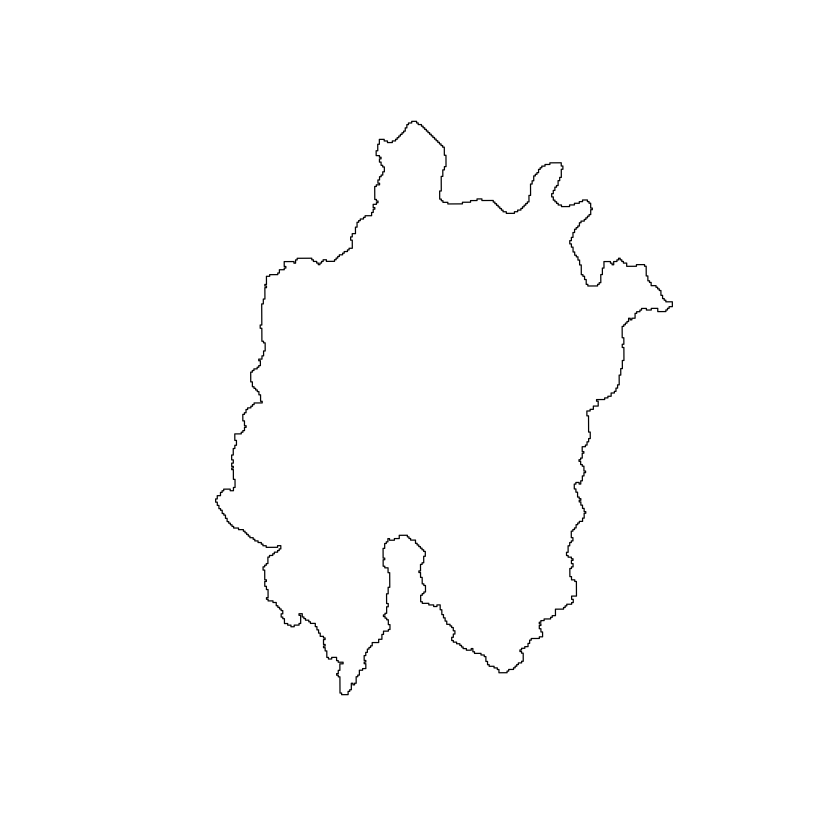

In [3]:
# get boundary of area
boundary = st_union(DJ_area$geom)
plot(boundary, bg='white')

In [4]:
# read crime data
df_crime = read_csv('STKDE/data_100M.csv')
spec(df_crime)

Rows: 2819 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): geometry
dbl  (3): T, X, Y
dttm (1): RECV_CPLT_DM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  RECV_CPLT_DM = col_datetime(format = ""),
  geometry = col_character(),
  T = col_double(),
  X = col_double(),
  Y = col_double()
)

In [5]:
ppp_crime <- ppp(x=df_crime$X, y=df_crime$Y, window = as.owin(boundary), marks = df_crime$T)

Warning message:
“48 points were rejected as lying outside the specified window”
Warning message:
“data contain duplicated points”


## Oversmoothing bandwidth

In [37]:
hlam_os <- OS.spattemp(ppp_crime) # oversmoothing bd for crime data in Daejeon
hlam_os

h    lambda 
692.46840  25.28843

## Likelihood CV selector
$$
h_{LIK} = \arg\max_h [LIK(h|\mathbf{X})]
$$
where
$$
LIK(h|\mathbf{X}) = {1\over n}\sum_{i=1}^n\log[\tilde f_h (x_i|\mathbf{X}_{-i})]
$$

In [15]:
# likelihood cv selector
hlam <- LIK.spattemp(ppp_crime)

h = 692.4684; lambda = 6.948981 
h = 761.7152; lambda = 6.948981 
h = 692.4684; lambda = 76.19582 
h = 623.2216; lambda = 76.19582 
h = 553.9747; lambda = 110.8192 
h = 553.9747; lambda = 180.0661 
h = 588.5981; lambda = 136.7868 
h = 415.481; lambda = 214.6895 
h = 276.9874; lambda = 283.9363 
h = 276.9874; lambda = 214.6895 
h = 138.4937; lambda = 232.0012 
h = 415.481; lambda = 180.0661 
h = 138.4937; lambda = 318.5598 
h = 346.2342; lambda = 214.6895 
h = 207.7405; lambda = 283.9363 
h = 311.6108; lambda = 232.0012 
h = 242.3639; lambda = 266.6246 
h = 294.2991; lambda = 240.6571 
h = 259.6756; lambda = 257.9688 
h = 285.6432; lambda = 244.985 
h = 285.6432; lambda = 175.7382 
h = 289.9711; lambda = 121.6391 
h = 276.9874; lambda = 145.4427 
h = 272.6594; lambda = 95.67149 
h = 285.6432; lambda = 106.4913 
h = 279.1513; lambda = 187.64 
h = 283.4793; lambda = 133.5409 
h = 285.6432; lambda = 106.4913 
h = 274.8234; lambda = 103.2454 
h = 282.9383; lambda = 157.615 
h = 289.4302; la

In [16]:
# result
hlam # 282, 149

h   lambda 
282.8621 149.0015

## Density Estimation
with LooCV optimal bandwidth

In [19]:
range(marks(ppp_crime))

[1]   0 364

In [38]:
# STKDE and oversmoothing STKDE
f.crime <- spattemp.density(
    ppp_crime, h=hlam[1], lambda=hlam[2], tlim = c(-10,370)
)
f.crime_os <- spattemp.density(
    ppp_crime, h=hlam_os[1], lambda=hlam_os[2], tlim = c(-10,370)
)

Calculating trivariate smooth...
Done.

Edge-correcting...
Done.

Conditioning on time...
Done.

Calculating trivariate smooth...
Done.

Edge-correcting...
Done.

Conditioning on time...
Done.



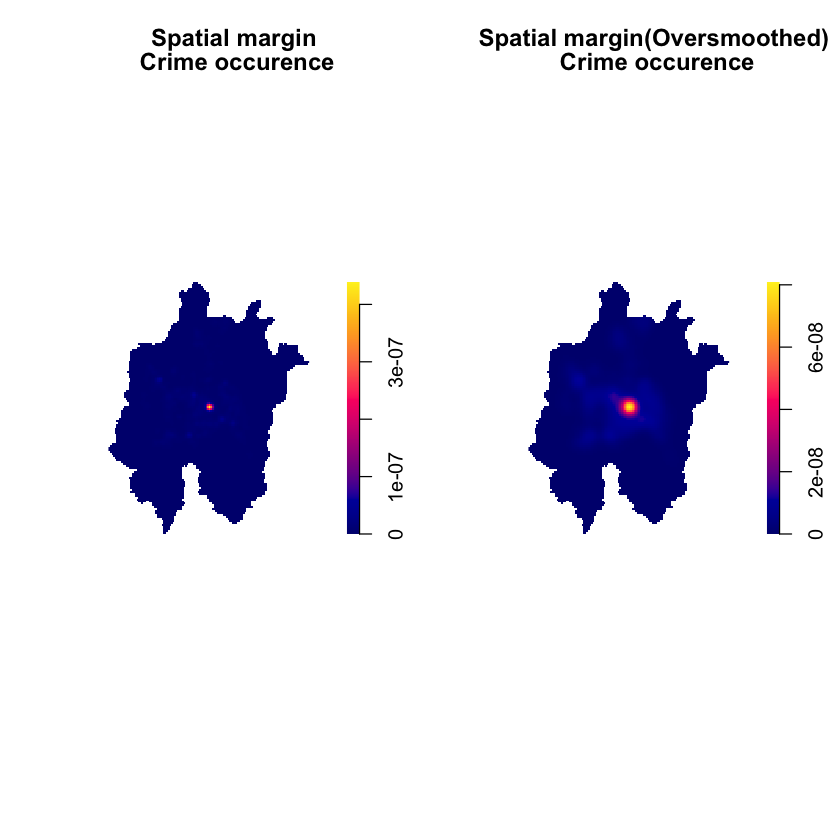

In [45]:
## spatial margin plot
par(mfrow=c(1,2))
plot(f.crime$spatial.z, box=FALSE, main="Spatial margin\n Crime occurence", bg='white')
plot(f.crime_os$spatial.z, box=FALSE, main="Spatial margin(Oversmoothed)\n Crime occurence", bg='white')

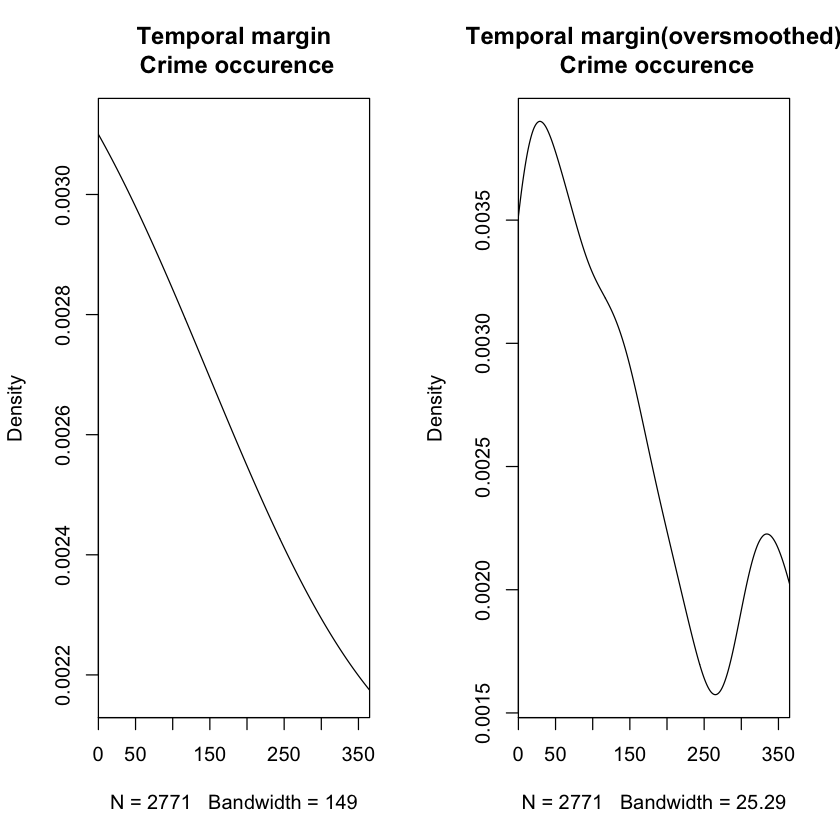

In [47]:
# Temporal Margin plot
par(mfrow=c(1,2))
plot(f.crime$temporal.z, xlim=c(0,365), xaxs="i", main="Temporal margin\n Crime occurence", bg='white')
plot(f.crime_os$temporal.z, xlim=c(0,365), xaxs="i", main="Temporal margin(oversmoothed)\n Crime occurence", bg='white')